## Vanilla Policy Gradient

## Create an Environment

In [90]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [91]:
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00331793  1.4038675   0.3360535  -0.31345463 -0.00383786 -0.07612097
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


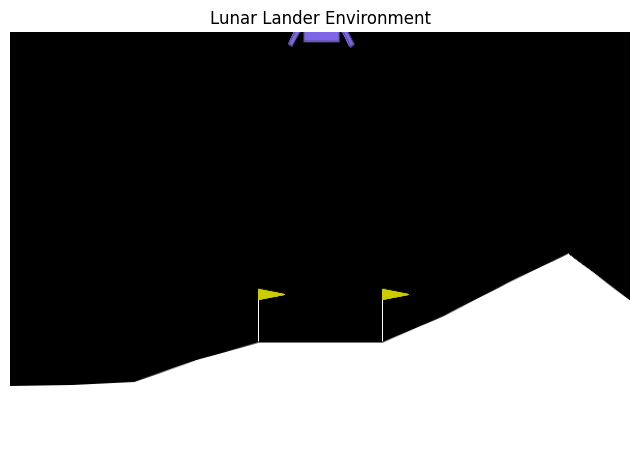

In [92]:
# Reset the environment to get the initial state
state, info = env.reset()

# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Create VPG Components

In [93]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam, Optimizer

from typing import Tuple

In [94]:
class MLP(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [95]:
class VPGPolicy:
    def __init__(self, num_inputs: int, num_outputs: int, device: torch.device, learning_rate: float = 0.003) -> None:
        self.device = device
        self.policy_network = MLP(num_inputs, num_outputs)
        self.policy_network.to(self.device)
        self.optimizer = Adam(params=self.policy_network.parameters(), lr=learning_rate)

    def select_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        Selects an action based on the current state and computes its log-probability.

        Args:
            state (torch.Tensor): The current state represented as a tensor.

        Returns:
            Tuple[int, torch.Tensor]:
                - action (int): The chosen action index.
                - log_prob (torch.Tensor): The log-probability of the chosen action.
        """
        # Forward pass through the policy network to get action logits.
        action_logits = self.policy_network(state)

        # Create a categorical distribution from the logits.
        action_distribution = Categorical(logits=action_logits)

        # Sample an action from the distribution.
        sampled_action = action_distribution.sample()

        # Convert the sampled action to a Python integer.
        action_index = int(sampled_action.item())

        # Calculate the log-probability of the selected action.
        log_prob = action_distribution.log_prob(sampled_action)

        return action_index, log_prob

    def calculate_policy_loss(
        self, episode_log_probability_actions: torch.Tensor, episode_action_rewards: torch.Tensor
    ):
        """
        The loss is negated because most optimization libraries (like PyTorch) perform minimization,
        while the policy gradient aims to maximize the objective J(θ).
        """
        return -(episode_log_probability_actions * episode_action_rewards).mean()

    def optimize_policy(self, episode_log_probability_actions: torch.Tensor, episode_action_rewards: torch.Tensor):
        loss = self.calculate_policy_loss(episode_log_probability_actions, episode_action_rewards)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

### Training

In [96]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# print("Using device: ", device)

device = torch.device("cpu")

In [97]:
learning_rate = 0.003

policy = VPGPolicy(num_inputs=n_observations, num_outputs=n_actions, learning_rate=learning_rate, device=device)

In [98]:
def train_policy_on_one_episode(env: gym.Env, policy: VPGPolicy, device: torch.device) -> dict:
    """
    Runs one episode of training for the policy in the given environment.

    Args:
        env: The environment to interact with (following the OpenAI Gym interface).
        policy: The policy object that defines action selection and optimization.

    Returns:
        dict: A dictionary of metrics tracking episode performance and training progress.
    """
    # Lists to store log-probabilities of actions and rewards for the episode
    log_probs_list = []
    rewards_list = []

    # Initialize episode reward and step counter
    total_episode_reward = 0.0
    steps_taken = 0

    # Reset the environment for a new episode
    state, _ = env.reset()

    while True:
        # Convert state to a tensor
        state_tensor = torch.Tensor(state)
        state_tensor = state_tensor.to(device)

        # Select an action using the policy and get its log-probability
        action, log_prob = policy.select_action(state=state_tensor)

        # Take the selected action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action=action)

        # Store log-probability and reward
        log_probs_list.append(log_prob)
        rewards_list.append(reward)

        # Update cumulative reward
        total_episode_reward += reward

        # Update state and step counter
        state = next_state
        steps_taken += 1

        # Exit the loop if the episode ends
        if terminated or truncated:
            break

    # Convert collected data to tensors
    log_probs_tensor = torch.stack(log_probs_list)  # Log-probabilities for all actions taken
    rewards_tensor = torch.Tensor(rewards_list)  # Rewards received during the episode

    log_probs_tensor = log_probs_tensor.to(device)
    rewards_tensor = rewards_tensor.to(device)

    # Compute the return (discounted rewards) for policy optimization
    # returns_tensor = compute_discounted_returns(rewards_tensor, gamma=policy.gamma)

    # Optimize the policy
    policy_loss = policy.optimize_policy(log_probs_tensor, rewards_tensor)

    # Return metrics to track training progress
    metrics = {
        "episode_reward": total_episode_reward,
        "steps_taken": steps_taken,
        "policy_loss": policy_loss,
    }

    return metrics

In [103]:
def train_vpg_policy(max_episodes: int = 500):
    
    reward_threshold = 200  # Target for "solved" in Lunar Lander
    rewards_history = []
    loss_history = []
    steps_history = []

    for episode in range(max_episodes):
        metrics = train_policy_on_one_episode(env, policy, device)

        # Collect metrics
        rewards_history.append(metrics["episode_reward"])
        loss_history.append(metrics["policy_loss"])
        steps_history.append(metrics["steps_taken"])

        # Print metrics every 50 episodes
        if episode % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:])
            print(f"Episode {episode}: Average Reward: {avg_reward}, Loss: {metrics['policy_loss'] : .4f}, Steps: {metrics['steps_taken']}")

        # Check convergence (solving condition)
        if len(rewards_history) >= 100 and np.mean(rewards_history[-100:]) >= reward_threshold:
            print(f"Environment solved in {episode + 1} episodes!")
            break

    env.close()

    return rewards_history, loss_history, steps_history


In [ ]:
rewards_history, loss_history, steps_history = train_vpg_policy(max_episodes=50)

Episode 0: Average Reward: -413.4776692630029, Loss: -5.1396098136901855, Steps: 107
Episode 50: Average Reward: -425.7804941291074, Loss: -1.2635306119918823, Steps: 105
Episode 100: Average Reward: -188.79744238799515, Loss: -1.1577503681182861, Steps: 137
Episode 150: Average Reward: -265.7070379793048, Loss: -0.6950559020042419, Steps: 98
Episode 200: Average Reward: -290.61194520032774, Loss: -1.1474814414978027, Steps: 110
Episode 250: Average Reward: -260.4633075766067, Loss: -0.9798973202705383, Steps: 121
Episode 300: Average Reward: -226.3971887705259, Loss: -0.43734225630760193, Steps: 296


KeyboardInterrupt: 

In [ ]:
# Plot metrics
plt.figure(figsize=(16, 5))

# Plot rewards
plt.subplot(1, 3, 1)
plt.plot(rewards_history, label="Reward per Episode")
plt.axhline(y=reward_threshold, color="r", linestyle="--", label="Reward Threshold")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(loss_history, label="Loss per Episode", color="orange")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Policy Loss")
plt.legend()

# Plot steps
plt.subplot(1, 3, 3)
plt.plot(steps_history, label="Steps per Episode", color="green")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps Taken")
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete.")